# Transfer Learning with TensorFlow pt2: Fine-tuning

## Creating helper functions

In [1]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

--2023-06-13 17:19:44--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'helper_functions.py'

     0K .......... .......... .......... .......... ..........  292K
    50K .......... .......... .......... .......... ..........  482K
   100K .......... .......... .......... .......... ..........  334K
   150K .......... .......... .......... .......... .......... 3,74M
   200K .......... .......... .......... .......... ..........  515K
   250K .........                                               180G=0,5s

2023-06-13 17:19:46 (485 KB/s) - 'helper_functions.py' saved [265682]



In [2]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions

### Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of the training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip data
unzip_data("10_food_classes_10_percent.zip")

In [4]:
# Check out how many images and sub-directories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [5]:
# Create training and test dirs
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [6]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out the class names of our data
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [9]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 7s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [10]:
# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [11]:
# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)), # validate for less steps
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230613-175141
Epoch 1/5
24/24 [==============================] - 10s 224ms/step - loss: 1.8984 - accuracy: 0.4107 - val_loss: 1.3290 - val_accuracy: 0.7171
Epoch 2/5
24/24 [==============================] - 4s 183ms/step - loss: 1.1121 - accuracy: 0.7533 - val_loss: 0.8667 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 4s 183ms/step - loss: 0.8031 - accuracy: 0.8280 - val_loss: 0.7037 - val_accuracy: 0.8487
Epoch 4/5
24/24 [==============================] - 4s 186ms/step - loss: 0.6486 - accuracy: 0.8627 - val_loss: 0.5983 - val_accuracy: 0.8668
Epoch 5/5
24/24 [==============================] - 4s 187ms/step - loss: 0.5582 - accuracy: 0.8800 - val_loss: 0.5534 - val_accuracy: 0.8684


In [12]:
# Evaluate on the test data
model_0.evaluate(test_data)

79/79 [==============================] - 8s 100ms/step - loss: 0.5558 - accuracy: 0.8640


[0.5558309555053711, 0.8640000224113464]

In [13]:
# Check out the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [14]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


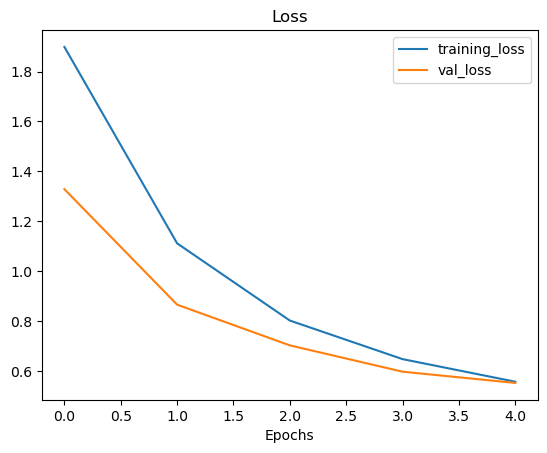

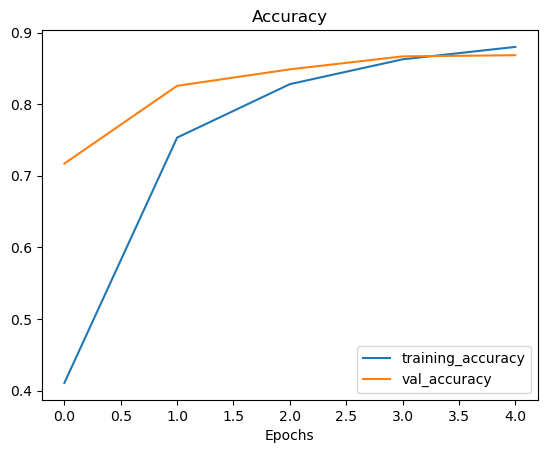

In [16]:
# Check out the training curves
plot_loss_curves(history_10_percent)

### Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turn into (None,1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and ten pass it to GlobalAveragePooling2D

In [22]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

print("Shape of input tensor:", input_tensor.shape)
print("Shape of global average pooled 2D tensor:", global_average_pooled_tensor.shape)

Random input tensor:
 [[[[ 0.3274686  -0.8426257   0.31943342]
   [-1.4075519  -2.3880594  -1.039248  ]
   [-0.55732316  0.53970677  1.6994323 ]
   [ 0.28893653 -1.5066113  -0.26454788]]

  [[-0.59722424 -1.9171128  -0.62044096]
   [ 0.8504024  -0.40604675 -3.025841  ]
   [ 0.9058464   0.29855967 -0.2256155 ]
   [-0.76164424 -1.8917137  -0.9384714 ]]

  [[ 0.778522   -0.4733888   0.97772676]
   [ 0.24694404  0.20573732 -0.52562314]
   [ 0.32410017  0.02545412 -0.10638462]
   [-0.63694745  1.160312    0.25073585]]

  [[-0.41728505  0.40125757 -1.4145439 ]
   [-0.59318614 -1.6617215   0.335671  ]
   [ 0.10815619  0.2347966  -0.5666874 ]
   [-0.3581984   0.8869861   0.52744746]]]]

2D global average pooled random tensor:
 [[-0.09368651 -0.4584043  -0.28855985]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D tensor: (1, 3)


In [23]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368651, -0.4584043 , -0.28855985]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation 
3. `model_3` - use fine-tuning transer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

In [4]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [5]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [9]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE) # default = 32
                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation?hl=tr#use_keras_preprocessing_layers

Off the top our of heads, after reading the docs, thebenefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


In [11]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # if using a model such as ResNet50V2, you'll need to rescale your data, EfficientNet's do this automatically
], name="data_augmentation")

### Visualize our data augmentation layer

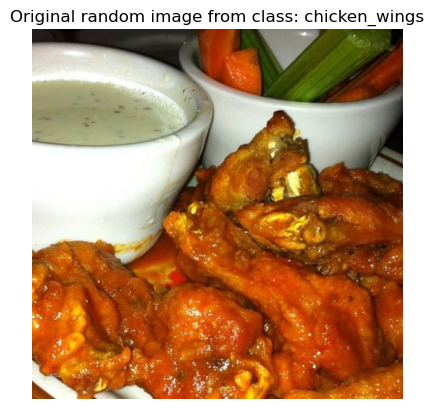

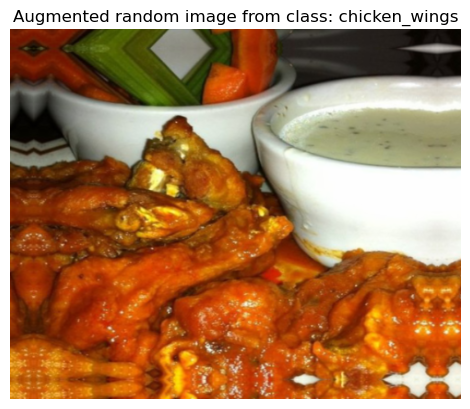

In [16]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the chosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [18]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs) # augment our training images

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool the outputs of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense classifier on top of the outputs of the global average pooling layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

In [19]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [20]:
# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)), # validate for less steps
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230614-121708
Epoch 1/5
3/3 [==============================] - 12s 2s/step - loss: 2.3417 - accuracy: 0.1286 - val_loss: 2.1589 - val_accuracy: 0.1990
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.0854 - accuracy: 0.3000 - val_loss: 2.0475 - val_accuracy: 0.2961
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.8614 - accuracy: 0.4571 - val_loss: 1.9341 - val_accuracy: 0.3734
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7360 - accuracy: 0.4857 - val_loss: 1.8132 - val_accuracy: 0.4359
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5384 - accuracy: 0.6571 - val_loss: 1.7419 - val_accuracy: 0.4786


In [21]:
# Check out the model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [22]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 1.7488 - accuracy: 0.4988


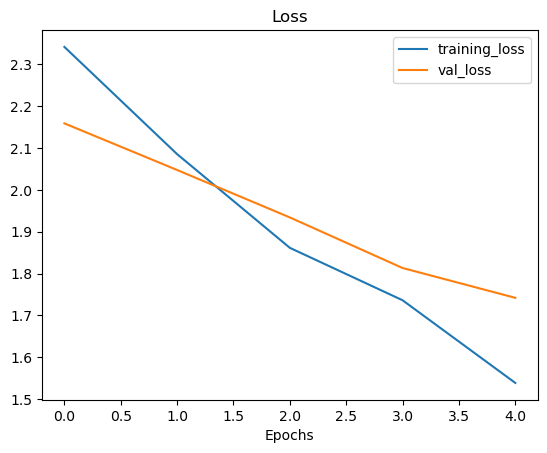

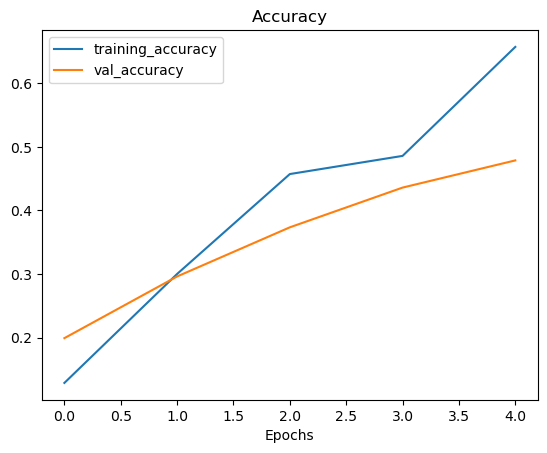

In [23]:
# How  do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [ ]:
# get 10% of the data of the 10 classes of food (run if you dont have)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

In [24]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [25]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",   
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [65]:
# Create model_2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescale(1./255) # if using a model such as ResNet50V2, you'll need to rescale your data, EfficientNet's do this automatically
], name="data_augmentation")

# Setup input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model(also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated

# Pool the outputs of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense classifier on top of the outputs of the global average pooling layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_2 = tf.keras.Model(inputs, outputs)

In [66]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Creating a ModelCheckpoint callback

In [33]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # unique name for checkpoint

# Create a ModelCheckpoint callback that saves the model's weights only

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                            save_weights_only=True, # set to False to save the entire model
                                                            save_best_only=False, # set to True to save only the best model instead of a model every epoch
                                                            save_freq="epoch", # save every epoch
                                                            verbose=1)

In [67]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                            epochs=initial_epochs,
                                            validation_data=test_data,
                                            validation_steps=int(0.25 * len(test_data)),
                                            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                    experiment_name="10_percent_data_aug"),
                                                        checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230614-135954
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9852 - accuracy: 0.3400
Epoch 1: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 20s 553ms/step - loss: 1.9852 - accuracy: 0.3400 - val_loss: 1.5922 - val_accuracy: 0.5280
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2995 - accuracy: 0.7080
Epoch 2: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 12s 508ms/step - loss: 1.2995 - accuracy: 0.7080 - val_loss: 1.1815 - val_accuracy: 0.6760
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9980 - accuracy: 0.7560
Epoch 3: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 12s 506ms/step - loss: 0.9980 - accuracy: 0.7560 - val_loss: 0.9949 - val_accuracy: 0.7220
E

In [68]:
# Evaluate on the test data
results_10_percent_data_aug =model_2.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 103ms/step - loss: 0.6231 - accuracy: 0.8476


[1.748758316040039, 0.49880000948905945]

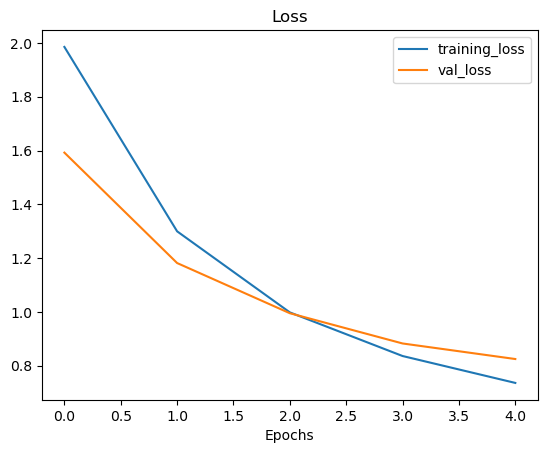

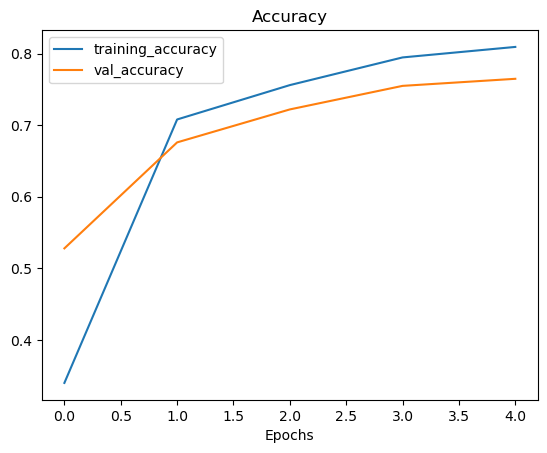

In [69]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [41]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [42]:
# Evaluate loaded model
loaded_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 103ms/step - loss: 0.6025 - accuracy: 0.8476


In [46]:
print(loaded_model_results == results_10_percent_data_aug)


(loaded_model_results, results_10_percent_data_aug)

True


([0.6024516820907593, 0.8476000428199768],
 [0.6024516820907593, 0.8476000428199768])

## Model 3: Fine-tuning an existing model on 10% of the data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [47]:
model_2.layers

In [48]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000025021F26F50> True
<keras.engine.sequential.Sequential object at 0x000002504C7DE740> True
<keras.engine.functional.Functional object at 0x0000025021F11FF0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000024F8FD18FD0> True
<keras.layers.core.dense.Dense object at 0x000002504CA9AE90> True


In [49]:
for layer in model_2.layers[2].layers:
    print(layer.name, layer.trainable)

input_3 False
rescaling_4 False
normalization_2 False
rescaling_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [70]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True

base_model.trainable = True

# Freeze all layers except for last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [51]:
# Recompile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])


In [52]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [53]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                                epochs=fine_tune_epochs,
                                                validation_data=test_data,
                                                validation_steps=int(0.25 * len(test_data)),
                                                initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                        experiment_name="10_percent_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230614-133453
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.7007 - accuracy: 0.7840
Epoch 5: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 21s 561ms/step - loss: 0.7007 - accuracy: 0.7840 - val_loss: 0.4829 - val_accuracy: 0.8487
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.8907
Epoch 6: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 13s 521ms/step - loss: 0.3433 - accuracy: 0.8907 - val_loss: 0.5028 - val_accuracy: 0.8520
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9160
Epoch 7: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 13s 522ms/step - loss: 0.2461 - accuracy: 0.9160 - val_loss: 0.4819 - val_accura

In [54]:
# Evaluate again on all of the test data
results_fine_tune_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.5350 - accuracy: 0.8440


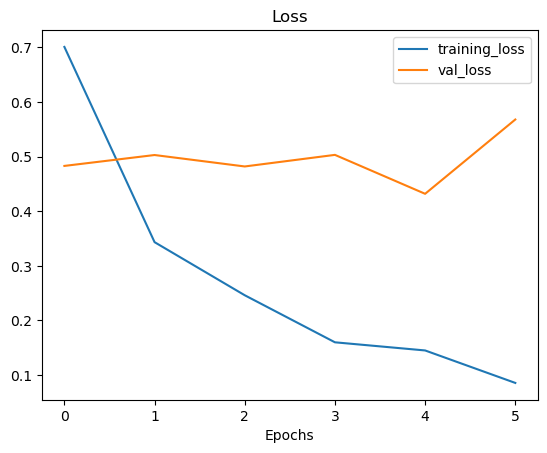

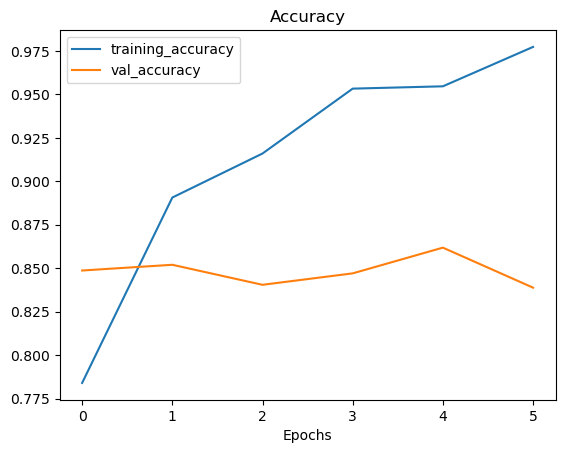

In [55]:
# Plot the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with model which have only been fit once, however, we want something to compare on series of running `fit()` with another (e.g. before and after fine-tuning)

In [57]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow History objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history metrics with new_history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1],
                plt.ylim(), label="Start Fine Tuning") # reshift plot around epochs
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Make plots for loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Val Loss")
    plt.plot([initial_epochs-1, initial_epochs-1],
                plt.ylim(), label="Start Fine Tuning") # reshift plot around epochs
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.xlabel("epoch")
    plt.show()

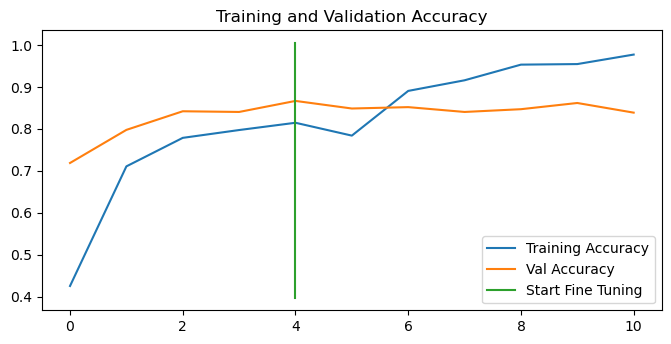

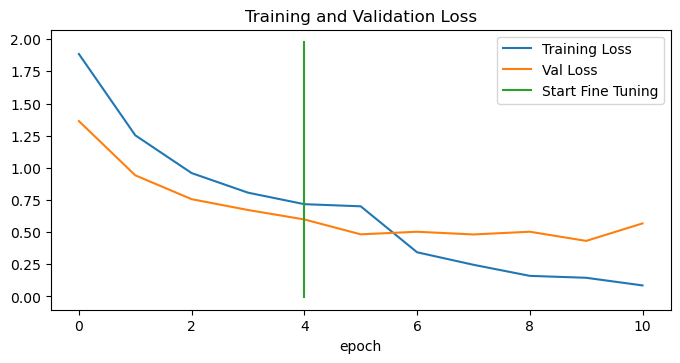

In [58]:
# Compare results of model_2 history and model_2 fine-tuned for 5 epochs history
compare_historys(original_history=history_10_percent_data_aug,
                    new_history=history_fine_10_percent_data_aug,
                    initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data

In [59]:
# Download and unzip 10 food classes with all images 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2023-06-14 13:45:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.181.240, 142.250.186.144, 142.250.186.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.181.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: '10_food_classes_all_data.zip.1'

     0K .......... .......... .......... .......... ..........  0%  405K 20m51s
    50K .......... .......... .......... .......... ..........  0%  476K 19m17s
   100K .......... .......... .......... .......... ..........  0% 9,27M 13m9s
   150K .......... .......... .......... .......... ..........  0%  310K 16m41s
   200K .......... .......... .......... .......... ..........  0%  207K 21m30s
   250K .......... .......... .......... .......... ..........  0% 10,2M 18m3s
   300K .......... .......... .......... .......... .......... 

In [60]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [61]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [62]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                            
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [63]:
# Evaluate model (this is the fine-tuned 10_percent_data_augmentation model)
model_2.evaluate(test_data)

79/79 [==============================] - 8s 102ms/step - loss: 0.5350 - accuracy: 0.8440


[0.5349569916725159, 0.8440000414848328]

In [73]:
results_10_percent_data_aug

[0.623060941696167, 0.8476000428199768]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [71]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data augmentation model finished training to
model_2.load_weights(checkpoint_path)

In [72]:
# Let's evaluate our model_2
loaded_model_2_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.6231 - accuracy: 0.8476


Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the models's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4)

In [74]:
# Check which layers are trainable 
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_6 False
2 normalization_3 False
3 rescaling_7 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [75]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [76]:
# Fit the model with all the data
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                            epochs=fine_tune_epochs,
                                            validation_data=test_data,
                                            validation_steps=int(0.25 * len(test_data)),
                                            initial_epoch=history_10_percent_data_aug.epoch[-1],
                                            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                    experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230614-140919
Epoch 5/10
235/235 [==============================] - 108s 428ms/step - loss: 0.6484 - accuracy: 0.7948 - val_loss: 0.4214 - val_accuracy: 0.8651
Epoch 6/10
235/235 [==============================] - 96s 407ms/step - loss: 0.5346 - accuracy: 0.8243 - val_loss: 0.3923 - val_accuracy: 0.8750
Epoch 7/10
235/235 [==============================] - 97s 410ms/step - loss: 0.4656 - accuracy: 0.8489 - val_loss: 0.3518 - val_accuracy: 0.8849
Epoch 8/10
235/235 [==============================] - 97s 414ms/step - loss: 0.4326 - accuracy: 0.8637 - val_loss: 0.3341 - val_accuracy: 0.8882
Epoch 9/10
235/235 [==============================] - 97s 411ms/step - loss: 0.3958 - accuracy: 0.8717 - val_loss: 0.3184 - val_accuracy: 0.8997
Epoch 10/10
235/235 [==============================] - 96s 410ms/step - loss: 0.3619 - accuracy: 0.8840 - val_loss: 0.2815 - val_accuracy: 0.9013


In [77]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 8s 103ms/step - loss: 0.2762 - accuracy: 0.9120


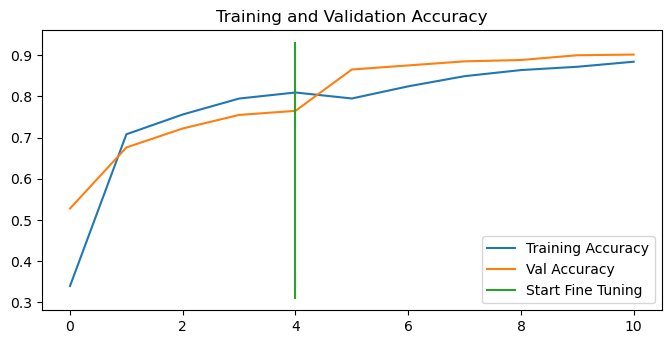

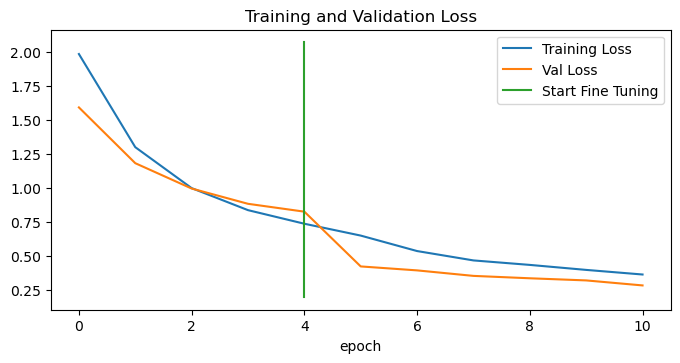

In [78]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                    new_history=history_fine_10_classes_full,
                    initial_epochs=5)

## Viewing our experiment data on TensorBoard

> 🔑 **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do NOT upload.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
    --name "Transfer Learning Experiments with 10 Food101 Classes" \
    --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
    --one_shot 


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/867bt4DxRoWC2xnASk9IKA/

[2023-06-14T14:25:25] Started scanning logdir.
Data upload starting...
Uploading binary object (1.2 MB)...
Uploading binary object (1.2 MB)...
Uploading binary object (1.2 MB)...
Uploading binary object (1.2 MB)...
Uploading binary object (782.6 kB)...
Uploading binary object (1.3 MB)...
Uploading binary object (1.2 MB)...
Uploading binary object (1.3 MB)...
Uploading 228 scalars...
[2023-06-14T14:26:04] Total uploaded: 228 scalars, 0 tensors, 8 binary objects (9.5 MB)
[2023-06-14T14:26:04] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/867bt4DxRoWC2xnASk9IKA/


In [80]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/867bt4DxRoWC2xnASk9IKA/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   867bt4DxRoWC2xnASk9IKA
	Created              2023-06-14 14:25:25 (5 minutes ago)
	Updated              2023-06-14 14:26:05 (4 minutes ago)
	Runs                 16
	Tags                 5
	Scalars              228
	Tensor bytes         0
	Binary object bytes  9948138
https://tensorboard.dev/experiment/qRONTgZGQeqjI5zDowXOtQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of training images
	Id                   qRONTgZGQeqjI5zDowXOtQ
	Created              2023-06-13 17:02:47 (21 hours ago)
	Updated              2023-06-13 17:03:14 (21 hours ago)
	Runs                 4
	Tags                 5
	Scalars         

Total: 2 experiment(s)


In [ ]:
# Delete past experiments
# !tensorboard dev delete --experiment_id IDHERE